<a href="https://colab.research.google.com/github/suhaodatascichem/Soybean-Meal-price/blob/main/Soybean%20meal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [87]:
# required libraries
import pandas as pd
import numpy as np
import datetime as dt

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error
import time
from sklearn.metrics import mean_squared_error

In [89]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Read Data

In [90]:
# import from github
url = 'https://raw.githubusercontent.com/suhaodatascichem/Soybean-Meal-price/refs/heads/main/US%20Soybean%20Meal%20Futures%20Historical%20Data-daily.csv'
df_raw = pd.read_csv(url)

In [91]:
startdate = df_raw['Date'].min()
print('startdate is ', startdate)
enddate = df_raw['Date'].max()
print("startdate is ", enddate)


startdate is  01/01/2020
startdate is  12/31/2021


In [92]:
df_raw.head(1)

,Date,Price,Open,High,Low,Vol.,Change %
0,12/27/2024,310.5,315.2,315.6,310.1,NaN,-1.40%


In [93]:
# reverse df['Date]
df_raw = df_raw.iloc[::-1].reset_index(drop=True)


In [94]:
df_raw.head(1)

,Date,Price,Open,High,Low,Vol.,Change %
0,01/03/2017,308.3,313.0,314.2,308.2,2.39K,-1.47%


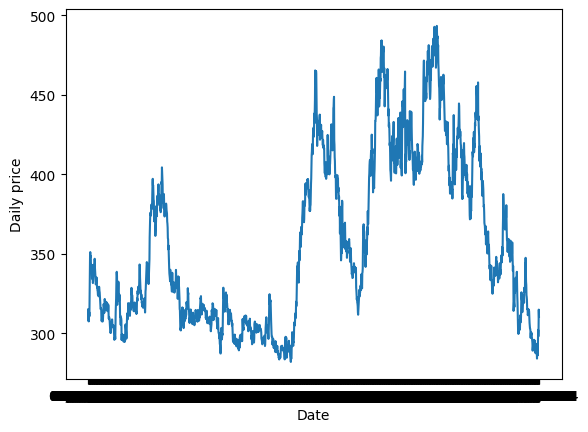

<Figure size 3200x200 with 0 Axes>

In [95]:
plt.plot(df_raw['Date'], df_raw["Price"])
plt.xlabel("Date")
plt.ylabel("Daily price")
plt.figure(figsize=(32,2))
plt.show()

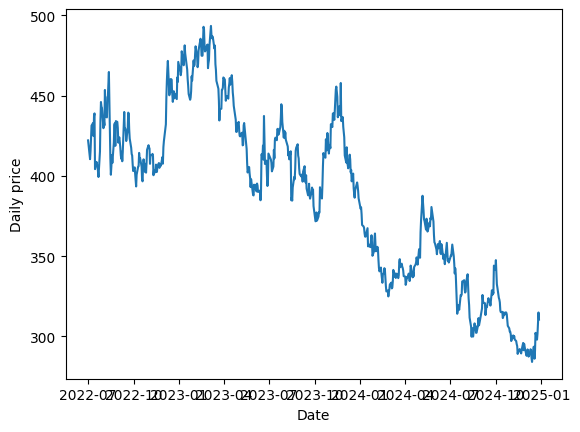

<Figure size 3200x200 with 0 Axes>

In [96]:
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df = df_raw[df_raw['Date'] > '2022-06-30']
plt.plot(df['Date'], df["Price"])
plt.xlabel("Date")
plt.ylabel("Daily price")
plt.figure(figsize=(32,2))
plt.show()

In [97]:
# min-max nomalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df[['Price']] = scaler.fit_transform(df[['Price']])

<ipython-input-97-bcbce0cf0b0b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Price']] = scaler.fit_transform(df[['Price']])


# LSTM only consider the period after covid, 2022-07 onwards

## Data Prep

In [98]:
#Function to perform the train test split on the df based on the desired window_size (ws)
def train_test_prep(series, x_variables, y_variables,  window_size, test_size):
  # series should be a numpy series
  x_series = series[x_variables].to_numpy()
  y_series = series[y_variables].to_numpy()

  x_data = []
  y_data = []
  for i in range(len(x_series) - window_size):
    x_data.append(x_series[i: i+window_size])
    y_data.append(y_series[i+window_size])
  x_data = np.array(x_data)
  y_data = np.array(y_data)

  train_size = x_data.shape[0] - test_size

  train_x = x_data[:train_size, :,:]
  train_y = y_data[:train_size, :]

  test_x = x_data[train_size:train_size+test_size, :,:]
  test_y = y_data[train_size:train_size+test_size:, :]

  return [train_x, train_y, test_x, test_y]

In [99]:
ws = 30
test_size = 180

In [100]:
x_train, y_train, x_test, y_test = train_test_prep(df, ["Price"],["Price"], ws,test_size)

In [101]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((431, 30, 1), (180, 30, 1), (431, 1), (180, 1))

In [102]:
#Function to obtain train, test data as tensors for torch
def array_to_tensor(x_train, x_test, y_train, y_test):
  x_train_torch = torch.from_numpy(x_train).type(torch.Tensor).cuda()
  x_test_torch = torch.from_numpy(x_test).type(torch.Tensor).cuda()
  y_train_torch = torch.from_numpy(y_train).type(torch.Tensor).cuda()
  y_test_torch = torch.from_numpy(y_test).type(torch.Tensor).cuda()
  return x_train_torch, x_test_torch, y_train_torch, y_test_torch

In [103]:
x_train_torch, x_test_torch, y_train_torch, y_test_torch = array_to_tensor(x_train, x_test, y_train, y_test)

In [104]:
x_train_torch.shape, x_test_torch.shape, y_train_torch.shape, y_test_torch.shape

(torch.Size([431, 30, 1]),
 torch.Size([180, 30, 1]),
 torch.Size([431, 1]),
 torch.Size([180, 1]))

# Baseline model

In [105]:
# base line model that uses the previous time stamp's demand as the predicted demand

#function for baseline model
def baseline_rmse(df, ws, y_train_data, column_name):
  y_base_test = np.array(df[column_name][ws+y_train.shape[0]-1:-1],dtype=np.float32)
  y_base_label = np.array(df[column_name][ws+y_train.shape[0]:],dtype=np.float32)

  print(y_base_test, y_base_label)
  rmse_loss_test = np.sqrt(mean_squared_error(y_base_test, y_base_label))
  return rmse_loss_test

In [106]:
baseline_rmse(df, ws, y_train, 'Price')

[0.2565695  0.28666985 0.26516962 0.2517917  0.26612517 0.25465837
 0.2823698  0.29001433 0.29622552 0.3110368  0.30339226 0.28953654
 0.33540374 0.32393694 0.3100812  0.38604873 0.4209269  0.4945055
 0.47348303 0.45102724 0.42427137 0.41949356 0.39369327 0.4261825
 0.40898234 0.38795987 0.39225993 0.4147157  0.4037267  0.42857143
 0.42427137 0.46106067 0.4180602  0.378882   0.3559484  0.3530817
 0.33492595 0.32059246 0.33683708 0.35069278 0.33827043 0.35977066
 0.32584807 0.32107022 0.35069278 0.34400383 0.30625895 0.3191591
 0.2909699  0.30864787 0.35451505 0.3248925  0.30052558 0.3057812
 0.29574773 0.3100812  0.3162924  0.31533682 0.34925944 0.31485906
 0.29240325 0.2632585  0.27854753 0.26134735 0.14333493 0.1524128
 0.16865744 0.16244625 0.1552795  0.19923554 0.19732441 0.2006689
 0.23936933 0.23984711 0.24319158 0.21643575 0.20640229 0.20974678
 0.23698041 0.26086956 0.22216913 0.18872432 0.16913521 0.13186814
 0.10463449 0.07501195 0.10033445 0.09985667 0.07548973 0.11466794
 0

0.025034116399308158

# LSTM Model Architecture


In [107]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, num_epochs, dropout_rate):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [108]:
def build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs, dropout_rate):
  model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, num_epochs=num_epochs, dropout_rate=dropout_rate)
  model = model.cuda()
  cr = torch.nn.MSELoss(reduction='mean')
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  return model, cr, optimizer

In [109]:
input_dim = 1
output_dim = 1
dropout_rate = 0.3
# other Parameters
#num_layers = 2
#hidden_dim = 50
#num_epochs = 100


# Train LSTM Model

In [110]:
def train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs):
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)
  np.random.seed(42)
  torch.backends.cudnn.deterministic = True

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)
  start_time = time.time()
  lstm = []


  for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train_torch)
    loss = cr(y_train_pred, y_train_torch)
    train_hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      y_test_pred = model(x_test_torch)
      loss = cr(y_test_pred, y_test_torch)
      test_hist[t] = loss.item()
      #print("Epoch ", t, "train MSE: ", train_hist[t], "Test MSE:", test_hist[t])

  training_time = time.time()-start_time
  #print("Training time: {}".format(training_time))
  return y_train_pred, y_test_pred

# Get_RMSE



In [111]:
def get_RMSE(y_train_pred, y_train_torch , type='Train'):
  # invert predictions
  y_train_pred = y_train_pred.cpu().detach().numpy()
  y_train_final = y_train_torch.cpu().detach().numpy()

  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(y_train_final[:,0], y_train_pred[:,0]))
  print(f"{type} RMSE: ",trainScore)

  return trainScore

#Model parameters fine tuneing

In [112]:
# Function to vary the number of layers and hidden dimensions, and epochs to find the combination with the best RMSE
def model_tuning(x_train_torch, y_train_torch, x_test_torch, y_test_torch, input_dim, output_dim):
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)
  np.random.seed(42)
  torch.backends.cudnn.deterministic = True
  testscore = 0
  nl = 0
  hd = 0
  epochs = 0
  summary = []
  for num_epochs in [100, 200, 300, 400]:
    for num_layers in [2, 3, 4, 5]:
      for hidden_dim in [25, 50, 75, 100]:
        model, cr, optimizer = build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs,dropout_rate)
        y_train_pred, y_test_pred = train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs)
        train_score = get_RMSE(y_train_torch, y_train_pred, type='Train')
        # test_score = get_test_rmse(x_test_torch, y_test_torch, model, ws, test_size)
        test_score = get_RMSE(y_test_torch, y_test_pred, type='Test')
        print(", Number of layers: ", num_layers, ", Hidden dimensions: ", hidden_dim, ", Number of Epochs:", num_epochs)
        summary.append({
            'Number of layers': num_layers,
            'Hidden dimensions': hidden_dim,
            'Number of Epochs': num_epochs,
            'Train RMSE': train_score,
            'Test RMSE': test_score
        })

        if test_score < testscore or testscore == 0 :
          testscore = test_score
          nl = num_layers
          hd = hidden_dim
          epochs = num_epochs
  print("Optimum Number of layers:", nl, "Optimum Hidden dimensions:", hd, "Optimum Number of Epochs:",epochs,"Test RMSE:", testscore)
  return nl, hd, epochs, summary

In [113]:
nl, hd, epochs, summary = model_tuning(x_train_torch, y_train_torch, x_test_torch, y_test_torch, input_dim, output_dim)

Train RMSE:  0.049096464481953865
Test RMSE:  0.061799838194593816
, Number of layers:  2 , Hidden dimensions:  25 , Number of Epochs: 100
Train RMSE:  0.04783468289344437
Test RMSE:  0.04261303638447695
, Number of layers:  2 , Hidden dimensions:  50 , Number of Epochs: 100
Train RMSE:  0.05235843745960082
Test RMSE:  0.05046725859224685
, Number of layers:  2 , Hidden dimensions:  75 , Number of Epochs: 100
Train RMSE:  0.05535095603855616
Test RMSE:  0.07549826480733858
, Number of layers:  2 , Hidden dimensions:  100 , Number of Epochs: 100
Train RMSE:  0.0558690242002648
Test RMSE:  0.06620318204194403
, Number of layers:  3 , Hidden dimensions:  25 , Number of Epochs: 100
Train RMSE:  0.04606556394303977
Test RMSE:  0.04746765257971293
, Number of layers:  3 , Hidden dimensions:  50 , Number of Epochs: 100
Train RMSE:  0.06519271153998092
Test RMSE:  0.07389869193611902
, Number of layers:  3 , Hidden dimensions:  75 , Number of Epochs: 100
Train RMSE:  0.06675120473896949
Test R

In [114]:
summary_df = pd.DataFrame(summary)
summary_df

,Number of layers,Hidden dimensions,Number of Epochs,Train RMSE,Test RMSE
0,2,25,100,0.049096,0.061800
1,2,50,100,0.047835,0.042613
2,2,75,100,0.052358,0.050467
3,2,100,100,0.055351,0.075498
4,3,25,100,0.055869,0.066203
...,...,...,...,...,...
59,4,100,400,0.036799,0.068823
60,5,25,400,0.032516,0.084127
61,5,50,400,0.033189,0.074247
62,5,75,400,0.033469,0.062345


In [115]:
train_min_idx = summary_df['Train RMSE'].idxmin()
test_min_idx = summary_df['Test RMSE'].idxmin()

train_min_row = summary_df.loc[train_min_idx]
test_min_row = summary_df.loc[test_min_idx]

# Display the results
print("Row with the smallest Train Score: ", train_min_row)
#print(train_min_row)
print("\nRow with the smallest Test Score: ", test_min_row)

Row with the smallest Train Score:  Number of layers       5.000000
Hidden dimensions    100.000000
Number of Epochs     400.000000
Train RMSE             0.032491
Test RMSE              0.087483
Name: 63, dtype: float64

Row with the smallest Test Score:  Number of layers       2.000000
Hidden dimensions     50.000000
Number of Epochs     400.000000
Train RMSE             0.034844
Test RMSE              0.028219
Name: 49, dtype: float64


In [116]:
#from the above result, choose below parameters as the best
input_dim = 1
hidden_dim = 75
num_layers = 4
output_dim = 1
num_epochs = 400
dropout_rate = 0.3
model, cr, optimizer = build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs, dropout_rate)
y_train_pred, y_test_pred = train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs)


In [117]:
y_train.shape, y_train_pred.shape

((431, 1), torch.Size([431, 1]))

In [118]:
#reverse normalization
y_train = scaler.inverse_transform(y_train)
y_train_pred = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())
y_test = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_test_pred.cpu().detach().numpy())

In [119]:
y_test_pred[1]

array([338.4694], dtype=float32)

In [120]:
#original_train = pd.DataFrame(y_train)
#predict_test = pd.DataFrame(y_test_pred)
#original_test = pd.DataFrame(y_test)


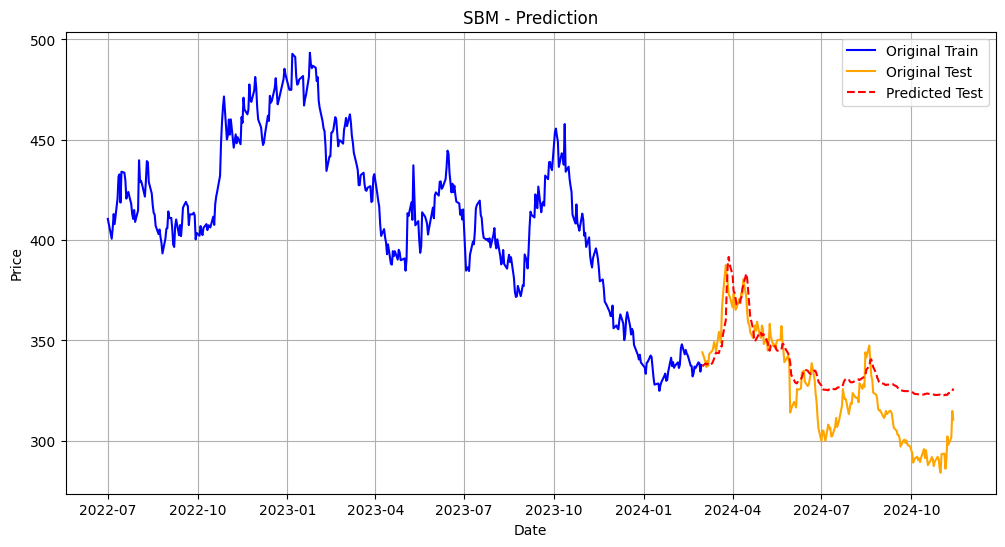

In [122]:
train_size = len(y_train)
test_size = len(y_test)
# Get the date ranges
train_dates = df['Date'][:431]
test_dates = df['Date'][train_size:train_size + test_size]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_dates, y_train, label='Original Train', color = 'blue')
plt.plot(test_dates, y_test, label='Original Test', color = 'orange')
plt.plot(test_dates, y_test_pred, label='Predicted Test', linestyle='--', color = 'Red')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SBM - Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train_size = len(original_train)

# Get the date ranges
train_dates = df['date_col'][:train_size]
test_dates = df['date_col'][train_size:]

# Create DataFrames for plotting
train_df = pd.DataFrame({'date': train_dates, 'value': original_train})
test_df = pd.DataFrame({'date': test_dates, 'value': original_test})
predict_df = pd.DataFrame({'date': test_dates, 'value': predict_test})

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_df['date'], train_df['value'], label='Original Train')
plt.plot(test_df['date'], test_df['value'], label='Original Test')
plt.plot(predict_df['date'], predict_df['value'], label='Predicted Test', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Train-Test-Prediction Plot')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = sns.lineplot(x = original_train.index, y = original_train.loc[1], label="Data", color='blue')
#ax = sns.lineplot(x = predict_train.index, y = predict[0], label="LSTM", color='red')
ax = sns.lineplot(x = original_test.index, y = original_test.loc[1], label="Data", color='yellow')
ax = sns.lineplot(x = predict_test.index, y = predict_test, label="LSTM", color='green')
ax.set_title('SBM price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


#plt.subplot(1, 2, 2)
#ax = sns.lineplot(data=hist, color='royalblue')
#ax.set_xlabel("Epoch", size = 14)
#ax.set_ylabel("Loss", size = 14)
#ax.set_title("Training Loss", size = 14, fontweight='bold')
#fig.set_figheight(6)
#fig.set_figwidth(16)

ValueError: array length 431 does not match index length 1

<Figure size 1200x1200 with 0 Axes>

#Get x months ahead worth of predictions

In [ ]:
#Function to take in the correct window of data and generate 5 months ahead predictions
def forecast_x_months(ws, df, model, months_ahead, column_name):
  predictions = []
  current_window = df[[column_name]][-ws:].to_numpy()
  current_window = current_window.reshape(1,ws,1)
  for i in range(months_ahead):
    current_window_torch = torch.from_numpy(current_window).type(torch.Tensor).cuda()
    pred = model(current_window_torch)
    pred = pred.cpu().detach().numpy()
    predictions.append(pred)
    current_window_torch = current_window_torch.cpu().detach().numpy()
    current_window = np.append(current_window, pred)
    current_window = current_window[-ws:].reshape(1,ws,1)
  predictions = scale.inverse_transform(np.array(predictions).reshape(months_ahead,1))
  return predictions

In [ ]:
#Function to take in the correct window of data and generate 6 months ahead predictions
def forecast_x_days(ws, df, model, months_ahead):
  predictions = []
  current_window = df['DailySalesQuantity'][-ws:].to_numpy()
  current_window = current_window.reshape(1,ws,1)
  for i in range(months_ahead):
    current_window_torch = torch.from_numpy(current_window).type(torch.Tensor).cuda()
    pred = model(current_window_torch)
    pred = pred.cpu().detach().numpy()
    predictions.append(pred)
    current_window_torch = current_window_torch.cpu().detach().numpy()
    current_window = np.append(current_window, pred)
    current_window = current_window[-ws:].reshape(1,ws,1)
  predictions = scale.inverse_transform(np.array(predictions).reshape(months_ahead,1))
  return predictions

In [ ]:
predictions = forecast_x_days(ws, df, model, test_size)
predictions

NameError: name 'model' is not defined

In [ ]:
  #Detach all torch tensors
  x_train_torch = x_train_torch.cpu().detach().numpy()
  x_test_torch = x_test_torch.cpu().detach()
  y_train_torch = y_train_torch.cpu().detach().numpy()
  y_test_torch = y_test_torch.cpu().detach().numpy()